In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/list-product-1/list_products.json
/kaggle/input/product-pairs-final/negative_examples_40000.npz
/kaggle/input/product-pairs-final/positive_examples_40000.npz
/kaggle/input/embedding-vectors-40k/product_name_embedding_vector_40000.npz
/kaggle/input/embedding-vectors-40k/image_embedding_vector_40000.npz
/kaggle/input/product-pair-examples/negative_examples.npz
/kaggle/input/product-pair-examples/positive_examples.npz


In [42]:
import random
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV

In [31]:
df = pd.read_json("/kaggle/input/list-product-1/list_products.json", lines = True)

In [32]:
data_images = np.load('/kaggle/input/embedding-vectors-40k/image_embedding_vector_40000.npz')
data_product_names = np.load('/kaggle/input/embedding-vectors-40k/product_name_embedding_vector_40000.npz')

In [33]:
vectorized_product_images = data_images["vectorized_product_images"]
vectorized_product_names = data_product_names["vectorized_product_names"]

In [34]:
cosine_similarity_product_names = cosine_similarity(vectorized_product_names)
cosine_similarity_product_images = cosine_similarity(vectorized_product_images)

In [35]:
data_negative_examples = np.load('/kaggle/input/product-pair-examples/negative_examples.npz')
data_positive_examples = np.load('/kaggle/input/product-pair-examples/positive_examples.npz')

In [36]:
negative_examples = data_negative_examples["negative_examples"]
positive_examples = data_positive_examples["positive_examples"]

In [37]:
examples = np.concatenate((negative_examples, positive_examples), axis=0)

In [38]:
X = np.empty((0, 3), float)
y = np.empty((0), int)
i = 0
for index, example in enumerate(examples):
    if (index % 1000 == 0):
        print(index) 
    x1 = cosine_similarity_product_names[example[0]][example[1]]
    x2 = cosine_similarity_product_images[example[0]][example[1]]
    
    x3 = abs(df.at[example[0], "price"] - df.at[example[1], "price"])
    if math.isnan(x3):
        printf(df.at[example[0], "price"], df.at[example[1], "price"], df.at[example[0], "price"] - df.at[example[1], "price"])
    X = np.append(X, [[x1, x2, x3]], axis=0)
    y = np.append(y, [1 if df.at[example[0], "group_id"] == df.at[example[1], "group_id"] else 0], axis=0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000


In [40]:
rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
param_grid = { 
    'bootstrap': True,
    'n_estimators': [100, 150, 200], 
    'max_features': ['sqrt', 'log2', "None"], 
    'max_depth': [2, 4], 
    'max_leaf_nodes': [3, 6], 
    "min_samples_split": [3, 6],
    "min_samples_leaf:": [3, 6]
} 

In [46]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = param_grid, 
                                   cv = skf, 
                                   scoring= ["accuracy", "precision", "recall", "f1"],
                                   refit="f1",
                                   verbose=2, 
                                   n_jobs = -1,
                                   n_iter= 10)
rf_RandomGrid.fit(X, y)
rf_RandomGrid.best_params_
rf_RandomGrid.cv_results_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'mean_fit_time': array([5.64352646, 6.63225198, 5.4375421 , 6.28755426, 5.50007644,
        7.16878262, 5.43640528, 6.61886792]),
 'std_fit_time': array([0.43082258, 0.36724161, 0.05050487, 0.06397645, 0.03533983,
        0.24503153, 0.07360484, 0.26405151]),
 'mean_score_time': array([0.154848  , 0.16490755, 0.15418372, 0.16480012, 0.16300664,
        0.16556454, 0.15377283, 0.14651814]),
 'std_score_time': array([0.00188745, 0.00217494, 0.00286363, 0.00252803, 0.01187665,
        0.00791534, 0.00154428, 0.01840707]),
 'param_n_estimators': masked_array(data=[100, 100, 100, 100, 100, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[3, 6, 3, 6, 3, 6, 3, 6],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'log2'

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

clf = RandomForestClassifier(n_estimators = 100, 
                             min_samples_split = 6, 
                             min_samples_leaf = 3,
                             max_depth = 3,
                             bootstrap = True
                   )

tree = RandomForestClassifier()

In [27]:
param_grid = { 
    'n_estimators': [100], 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [3, 6], 
    'max_leaf_nodes': [3, 6], 
} 

best_tree = GridSearchCV(estimator= tree, param_grid= param_grid, 
                         cv= skf, verbose= 5, n_jobs= -1, scoring= ["accuracy", "precision", "recall", "f1"], refit="f1")

best_tree.fit(X, y)
best_tree.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': 6,
 'n_estimators': 100}

In [19]:
lst_accu_stratified = []
precision_recall_fscores = []
lst_classification_is_wrong = []
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    print(np.count_nonzero(y_test_fold == 0))
    print(np.count_nonzero(y_test_fold == 1))
    clf.fit(x_train_fold, y_train_fold)
    y_pred = clf.predict(x_test_fold)
    lst_classification_is_wrong.append(test_index[y_test_fold != y_pred])
    precision_recall_fscores.append(precision_recall_fscore_support(y_test_fold, y_pred, average = "binary"))
    lst_accu_stratified.append(clf.score(x_test_fold, y_test_fold))
    
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

for index, precision_recall_fscore in enumerate(precision_recall_fscores):
    print('\nPrecision_recall_fscore {}: {}'.format(index, precision_recall_fscore))

9000
8805
9000
8805
9000
8804
9000
8804
9000
8804
List of possible accuracy: [0.9809604043807919, 0.9793878124122437, 0.9817456751291844, 0.9817456751291844, 0.9812401707481465]

Maximum Accuracy That can be obtained from this model is: 98.17456751291844 %

Minimum Accuracy: 97.93878124122438 %

Overall Accuracy: 98.10159475599102 %

Standard Deviation is: 0.0009707200668413825

Precision_recall_fscore 0: (0.9852132049518569, 0.9761499148211243, 0.9806606195447545, None)

Precision_recall_fscore 1: (0.9834975933990373, 0.9746734809767178, 0.9790656551252068, None)

Precision_recall_fscore 2: (0.9839059468097249, 0.9791004089050431, 0.9814972957586109, None)

Precision_recall_fscore 3: (0.9853463079564968, 0.9776238073602908, 0.9814698671532014, None)

Precision_recall_fscore 4: (0.9836683417085427, 0.9783053157655611, 0.9809794988610478, None)


In [20]:
import pickle
clf.fit(X, y)
with open('product_matching_model.pkl','wb') as f:
    pickle.dump(clf,f)

In [22]:
lst_classification_is_wrong[0]

array([ 1441,  1947,  2557,  2792,  3021,  3348,  3466,  3534,  3670,
        4673,  4730,  5073,  5126,  5137,  5297,  5462,  5949,  6034,
        6151,  6304,  6509,  6527,  6940,  7010,  7201,  7229,  7317,
        7442,  8117,  8519,  8819,  9242,  9609,  9657,  9837,  9888,
        9970, 10596, 10769, 11013, 11544, 11700, 11908, 12356, 12450,
       12897, 13469, 13696, 13781, 14014, 14727, 15097, 16430, 16904,
       16973, 17342, 17731, 17809, 17919, 18006, 19388, 19392, 19795,
       19930, 20034, 20062, 20318, 20441, 20447, 20629, 20711, 20747,
       20767, 21852, 22028, 22845, 23287, 23385, 23696, 24571, 24705,
       24889, 25159, 25201, 27226, 27742, 27756, 28213, 28562, 28684,
       31117, 31155, 32041, 32329, 32533, 32865, 33087, 33414, 33478,
       33776, 33782, 33787, 34201, 34819, 35909, 36305, 36420, 36735,
       36996, 37106, 37335, 38286, 38385, 38924, 40389, 41015, 41016,
       41099, 41537, 42021, 42256, 42513, 42576, 42942, 43084, 43737,
       44453, 44764,

In [23]:
right = 0
wrong = 0
for index, example in enumerate(examples[lst_classification_is_wrong[0]]):
    if y[lst_classification_is_wrong[0][index]] == 0:
        wrong +=1
    else:
        right += 1
    print(df.at[example[0] ,"name"])
    print(df.at[example[1] ,"name"])
    print(X[lst_classification_is_wrong[0][index]])
    print(y[lst_classification_is_wrong[0][index]])
    print("------")
print("right", right)
print("wrong", wrong)

Tai nghe không dây Baseus Encok S12 Bluetooth V5.0, tiêu chuẩn chống nước iPX5 cho điện thoại, máy nghe nhạc
[RẺ VÔ ĐỊCH] Tai Nghe Chuyên Game Wangming WM9600 7.1 USB Siêu Đẹp, Âm Siêu Hay ,Tai nghe ,tai nghe gaming ,tai nghe chụp tai Tai Nghe Game Thủ Wangming 9600 (7.1 Virtual Surround Sound) Chơi PUBG LOL-3HCOMPUTER
[5.55165708e-01 5.93499482e-01 9.90000000e+04]
0
------
Đầu Ghi Hình Camera 4 Kênh HikVision DS-7104HGHI-F1 Hỗ Trợ 1 Cổng Mic Hàng Chính Hãng Bảo Hành 2 Năm
Micro SHURE SM 959 Có Dây
[5.97102642e-01 5.28716981e-01 5.31000000e+05]
0
------
Máy tạo độ ẩm không khí thông minh Xiaomi Deerma DEM-F628S dung tích 5L đèn UV làm sạch nguồn nước - Bảo hành 6 tháng
Quạt lồng sắt 4 cánh USB 6inch
[5.87611675e-01 2.99285799e-01 6.22207000e+05]
0
------
Máy phun sương mini humidifier,Máy tạo độ ẩm phòng ,  phun sương tạo ẩm thông minh Deerma F628S, tốt cho sức khỏe, dễ dàng sử dụng
Combo Máy Hút Sữa Spectra 9Plus + Máy Hâm Nóng Và Tiệt Trùng 2 Bình Cổ Rộng FatzBaby FB3012SL
[6.2484645

Elapsed time to compute the importances: 0.043 seconds


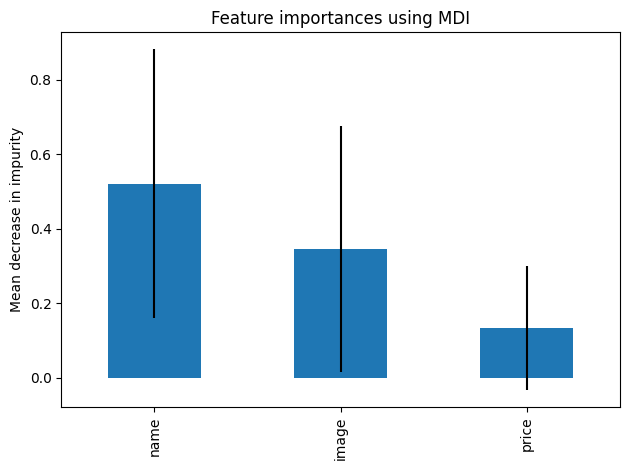

[CV 1/5] END max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=25;, score=0.979 total time=   1.5s
[CV 1/5] END max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=50;, score=0.979 total time=   3.6s
[CV 1/5] END max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=100;, score=0.978 total time=   5.4s
[CV 5/5] END max_depth=3, max_features=sqrt, max_leaf_nodes=3, n_estimators=100;, score=0.979 total time=   5.4s
[CV 3/5] END max_depth=3, max_features=sqrt, max_leaf_nodes=6, n_estimators=50;, score=0.980 total time=   3.4s
[CV 3/5] END max_depth=3, max_features=sqrt, max_leaf_nodes=6, n_estimators=100;, score=0.981 total time=   6.3s
[CV 1/5] END max_depth=3, max_features=log2, max_leaf_nodes=3, n_estimators=25;, score=0.969 total time=   1.4s
[CV 3/5] END max_depth=3, max_features=log2, max_leaf_nodes=3, n_estimators=25;, score=0.964 total time=   1.5s
[CV 1/5] END max_depth=3, max_features=log2, max_leaf_nodes=3, n_estimators=50;, score=0.980 total ti

In [24]:
clf = RandomForestClassifier(n_estimators = 500, 
                             min_samples_split = 6, 
                             min_samples_leaf = 3,
                             max_depth = 3,
                             bootstrap = True)
clf.fit(X, y)

feature_names = ["name", "image", "price"]
import time

import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
from matplotlib import pyplot as plt

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()